# EKF and EIF Localization Thesis
The EKF and the EIF are for the biggest part commented but still have lines that were needed for testing (like time and comparing). The landmark detection is partially commented but is for the biggest part work of OpenCV. Other parts of the code are less well commented and are mostly used for testing and plotting, thus no real complicated computations are performed that need clear explanation.

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt
from numpy.linalg import pinv as inv
import sys
import cv2 as cv
import csv
import glob
import time
import heapq
np.set_printoptions(suppress=True)
 
cos = math.cos
tan = math.tan
atan = math.atan
sin = math.sin
pi = math.pi

# Python 2/3 compatibility
PY3 = sys.version_info[0] == 3

if PY3:
    xrange = range

## Extended Kalman Filter

In [2]:
# INPUT
# robot pose at time t-1
# mean (mu) at time t-1
# covariance (Sigma) at time t-1
# control (u) at time t
# map (m)
# set of features (z = {z1, z2, ...}) at time t
# correspondence variables (c = {c1, c2, ...}) at time t
#
# OUTPUT
# mean (mu) at time t
# covariance (Sigma) at time t
# likelihood of feature observation (p_z_t)

def EKF_localization(mu_prior, Sigma_prior, u, z, c, m, Q, alpha_1, alpha_2, alpha_3, alpha_4):
    est_cor = list()
    t00 = time.time()
    v = u[0] # translational velocity
    w = -u[1] # rotational velocity, mirrored field, thus minus
    dt = 1
    
    # noise
    #alpha_1 = 0.10
    #alpha_2 = 0.05
    #alpha_3 = 0.05
    #alpha_4 = 0.10
 
    theta = mu_prior[2]
 
    # line 3 and 4 compute Jacobians for linearized motion model
    cos_var = -(v / w) * math.cos(theta) + (v / w) * math.cos(theta + w * dt)
    sin_var = -(v / w) * math.sin(theta) + (v / w) * math.sin(theta + w * dt)
    G = np.matrix([[1,0,cos_var],[0,1,sin_var],[0,0,1]])
 
    v00 = (-1 * (math.sin(theta) + math.sin(theta + w * dt))) / w
    v10 = (v * (math.sin(theta) - math.sin(theta + w * dt))) / (w**2) + (v * (math.cos(theta + w * dt) * dt) / w)
    v01 =((math.cos(theta) - math.cos(theta + w * dt))) / w
    v11 = (-1 * v * (math.cos(theta) - math.cos(theta + w * dt))) / (w**2) + (v * (math.sin(theta + w * dt) * dt) / w)
 
    v0 = np.concatenate((v00,v10),axis=1)
    v1 = np.concatenate((v01,v11),axis=1)
    V = np.concatenate((v0,v1, np.matrix([0,dt])))
 
    # line 5 determines the motion noise covariance matrix from control
    M = np.matrix([[alpha_1 * math.pow(v, 2) + alpha_2 * math.pow(w, 2), 0],[0, alpha_3 * math.pow(v, 2) + alpha_4 * math.pow(w, 2)]])
 
    # line 6 and 7 implement the familiar motion update
    # line 6 calculates predicted pose after the motion as mu
    # next line is version of x = g(u,x)
    mu = mu_prior + np.concatenate(((-v / w) * math.sin(theta) + (v / w) * math.sin(theta + w * dt), (v / w) * math.cos(theta) - (v / w) * math.cos(theta + w * dt), w * dt))
    
    # line 7 computes corresponding uncertainty ellips
    Sigma = G * Sigma_prior * G.transpose() + V * M * V.transpose()
 
    # line 8 to 21 perform the measurement update (correction step)
    # measurement noise, range, bearing, signature
    # Q is predetermined 
 
    
    est_cor.append(time.time() - t00)
    
    # line 10 assigns correspondence of i-th feature in measurement vector to j
    mu_corr = mu
    Sigma_corr = Sigma
    for i in range(0,np.shape(z)[1]):
        t01 = time.time()
        j = int(c[0,i])
        mj = m[j]
 
        q = (mj[0] - mu[0])**2 + (mj[1]-mu[1])**2
    
        # afterwards predicted measurement z and Jacobian H of the measurement model are calculated
        z_hat_1 = math.sqrt(q)
        z_hat_2 = math.atan2(mj[1] - mu[1], mj[0] - mu[0]) - mu[2]# + mu[2] + pi
        z_hat_old_temp = z_hat_2[0,0]
        z_hat_2 = z_hat_2[0,0] % (pi)
        if z_hat_2 > 0.5 * pi:
            z_hat_2 = z_hat_2 - pi
        z_hat_3 = mj[2]
        
        z_hat = np.matrix([[z_hat_1],[z_hat_2],[z_hat_3]])
        
        H00 = -(mj[0] - mu[0]) / math.sqrt(q)
        H10 = -(mj[1] - mu[1]) / math.sqrt(q)
        H01 = (mj[1] - mu[1]) / q
        H11 = -(mj[0] - mu[0]) / q
 
        H0 = np.concatenate((H00,H10,[[0.]]),axis=1)
        H1 = np.concatenate((H01,H11,[[-1.]]),axis=1)
        H2 = np.matrix([0., 0., 0.])
        H = np.concatenate((H0,H1,H2))
 
        # Jacobian is used to calculate the uncertainty (S) corresponding to the predicted measurement (z)
        S = H * Sigma * H.transpose() + Q
 
        # line 15 calculates Kalman Gain
        K = Sigma * H.transpose() * inv(S)
 
        # line 16 and 17 update estimate once for each feature
        I = np.identity(3)
        mu_corr = mu + K * (z[:,i] - z_hat)
        Sigma_corr = (I - K * H) * Sigma
        
    
        est_cor.append(time.time() - t01)
 
    # line 19 and 20 set new pose estimate
    # validation gate
    if math.sqrt((mu[0]-mu_corr[0])**2+(mu[1]-mu_corr[1])**2) < 3:
        #print math.sqrt((mu[0]-mu_corr[0])**2+(mu[1]-mu_corr[1])**2)
        mu = mu_corr
        Sigma = Sigma_corr
    # line 21 computes measurement likelihood
    # not necessary for now
 
    return mu, Sigma, est_cor

## Extended Information Filter

In [3]:
# INPUT
# robot pose at time t-1
# information vector (xi) at time t-1
# information filter (Omega) at time t-1
# control (u) at time t
# map (m)
# set of features (z = {z1, z2, ...}) at time t
# correspondence variables (c = {c1, c2, ...}) at time t
#
# OUTPUT
# information vector (xi) at time t
# information matrix (Omega) at time t
# likelihood of feature observation (p_z_t)

def EIF_localization(xi_prior, Omega_prior, u, z, c, m, Q, alpha_1, alpha_2, alpha_3, alpha_4):
    est_cor = list()
    t00 = time.time()
    v = u[0] # translational velocity
    w = -u[1] # rotational velocity, mirrored field, thus minus
    
    dt = 1
    
    mu_prior = inv(Omega_prior) * xi_prior
 
    # noise
    #alpha_1 = 0.10
    #alpha_2 = 0.05
    #alpha_3 = 0.05
    #alpha_4 = 0.10
 
    theta = mu_prior[2]
 
    # line 3 and 4 compute Jacobians for linearized motion model
    cos_var = -(v / w) * math.cos(theta) + (v / w) * math.cos(theta + w * dt)
    sin_var = -(v / w) * math.sin(theta) + (v / w) * math.sin(theta + w * dt)
    G = np.matrix([[1,0,cos_var],[0,1,sin_var],[0,0,1]])
 
    v00 = (-1 * (math.sin(theta) + math.sin(theta + w * dt))) / w
    v10 = (v * (math.sin(theta) - math.sin(theta + w * dt))) / (w**2) + (v * (math.cos(theta + w * dt) * dt) / w)
    v01 =((math.cos(theta) - math.cos(theta + w * dt))) / w
    v11 = (-1 * v * (math.cos(theta) - math.cos(theta + w * dt))) / (w**2) + (v * (math.sin(theta + w * dt) * dt) / w)
 
    v0 = np.concatenate((v00,v10),axis=1)
    v1 = np.concatenate((v01,v11),axis=1)
    V = np.concatenate((v0,v1, np.matrix([0,dt])))
 
    # line 5 determines the motion noise covariance matrix from control
    M = np.matrix([[alpha_1 * math.pow(v, 2) + alpha_2 * math.pow(w, 2), 0],[0, alpha_3 * math.pow(v, 2) + alpha_4 * math.pow(w, 2)]])
 
    # line 6 and 7 implement the familiar motion update
    # line 6 calculates predicted pose after the motion as mu
    # next line is version of x = g(u,x)
    mu = mu_prior + np.concatenate(((-v / w) * math.sin(theta) + (v / w) * math.sin(theta + w * dt), (v / w) * math.cos(theta) - (v / w) * math.cos(theta + w * dt), w * dt))
 
    # line 7 computes corresponding uncertainty ellips
    Omega = inv(G * inv(Omega_prior) * G.transpose() + V * M * V.transpose())
 
    # convert xi from Omega and mu
    xi = Omega * mu
 
    # line 8 to 21 perform the measurement update (correction step)
    # measurement noise, range, bearing, signature
    #sig_r = 0.2
    #sig_theta = 0.2
    #sig_s = 0.2
    #Q = np.matrix([[sig_r, 0., 0.],[0., sig_theta, 0.],[0., 0., sig_s]])
    est_cor.append(time.time() - t00)
    
    # line 10 assigns correspondence of i-th feature in measurement vector to j
    xi_corr = xi
    Omega_corr = Omega
    for i in range(0,np.shape(z)[1]):
        t01 = time.time()
        j = int(c[0,i])
        mj = m[j]
 
        q = (mj[0] - mu[0])**2 + (mj[1]-mu[1])**2
 
        # afterwards predicted measurement z and Jacobian H of the measurement model are calculated
        z_hat_1 = math.sqrt(q)
        z_hat_2 = math.atan2(mj[1] - mu[1], mj[0] - mu[0]) - mu[2]
        z_hat_old_temp = z_hat_2[0,0]
        z_hat_2 = z_hat_2[0,0] % (pi)
        if z_hat_2 > 0.5 * pi:
            z_hat_2 = z_hat_2 - pi
        z_hat_3 = mj[2]
        
        z_hat = np.matrix([[z_hat_1],[z_hat_2],[z_hat_3]])

        H00 = -(mj[0] - mu[0]) / math.sqrt(q)
        H10 = -(mj[1] - mu[1]) / math.sqrt(q)
        H01 = (mj[1] - mu[1]) / q
        H11 = -(mj[0] - mu[0]) / q
 
        H0 = np.concatenate((H00,H10,[[0.]]),axis=1)
        H1 = np.concatenate((H01,H11,[[-1.]]),axis=1)
        H2 = np.matrix([0., 0., 0.])
        H = np.concatenate((H0,H1,H2))

        # update estimate once for each feature
        inv_Q = inv(Q)
        Omega_corr = Omega + H.transpose() * inv_Q * H
        xi_corr = xi + H.transpose() * inv_Q * (z[:,i] - z_hat + H * mu)
        
        est_cor.append(time.time() - t01)
        
    # line 19 and 20 set new pose estimate
    if math.sqrt((xi[0] - xi_corr[0])**2 + (xi[1] - xi_corr[1])**2) < 3:
        #print math.sqrt((xi[0] - xi_corr[0])**2 + (xi[1] - xi_corr[1])**2)
        Omega = Omega_corr
        xi = xi_corr
    # line 21 computes measurement likelihood
    # not necessary for now
 
    return xi, Omega, est_cor

## Landmark Detector

In [4]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_values_for_tuning():
        empty_c = [0,0,0]
        c_1 = list()
        c_2 = list()
        c_3 = list()
        c = 0
        #for i in range(47, 77):#img.shape[0]):
        for i in range(152, 206):#img.shape[0]):
            for j in range(684, 740):#img.shape[1]):
                #print img[i,j][0]
                c_1.append(img[i,j][0])
                c_2.append(img[i,j][1])
                c_3.append(img[i,j][2])
                empty_c = empty_c + img[i,j]
                img[i,j] = [255, 255, 255]
                c = c + 1
        print max(c_1), min(c_1)
        print max(c_2), min(c_2)
        print max(c_3), min(c_3)
        print empty_c/c

def find_squares(img, n):
    img = cv.GaussianBlur(img, (n, n), 0)
    squares = []
    for gray in cv.split(img):
        for thrs in xrange(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            bin, contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in xrange(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
    return squares

# returns distance based on focus in cm
def get_distance_img(sign, P):
    landmark_heights = [21.9,19.7,21.2,21.5,21.6,21.8]
    landmark_names = ['pinkgreen', 'pinkyellow', 'pinkblue', 'bluepink', 'greenpink', 'yellowpink']
    landmark_focus = [1132.42009132,1197.96954315,1169.81132075,1190.69767442,1185.18518519,1192.66055046]# original
    landmark_focus = [1175.54604735,1202.55838686,1184.77240276,1188.83977963,1166.70046764,1177.76205385]# OptiTrack
    W = landmark_heights[landmark_names.index(sign)]
    F = landmark_focus[landmark_names.index(sign)]
    D = (F * W) / P
    # D is now in cm
    # D / 100 converts it in meter
    return D/100

# returns bearing in radians based on pixel location
def get_bearing_img(w, x_min, x_max):
    pixel_angle = (60.97 / w)
    B = pixel_angle * (0.5 * (x_max + x_min) - w / 2)
    B = math.radians(B)
    return B    

def detect_squares(take):
    z_data = list()
    from glob import glob
    landmark_names = ['pink', 'yellow', 'green', 'blue']
    pink = [90,70,120]
    yellow = [76,152,157]
    green = [46,47,29]
    blue = [120,92,37]

    fn_list = list()
    for fn in glob('Nao Pics/07-06-1630/Take ' + take + '/img/*.jpg'):
        #img = cv.imread(fn)
        #h, w, c = img.shape
        #img = img[int(h/1.6):,:,:]
        temp_landmarks_fn = []
        print
        print fn
        for n in range(1,33, 2):
            temp_landmarks_n = list()
            #print n
            img = cv.imread(fn)
            img_h, img_w, img_c = img.shape
            img = img[int(img_h/1.6):,:,:]
            squares = find_squares(img, n)
            squares = np.unique(squares,axis=0)
            landmarks = []
            for s in squares:
                maxw = max(s[:,0])
                minw = min(s[:,0])
                maxh = max(s[:,1])
                minh = min(s[:,1])
                w = maxw - minw
                h = maxh - minh
                if w < h:
                    w1 = minw + (w / 3)
                    w2 = maxw - (w / 3)
                    h1 = minh + (h / 3)
                    h2 = maxh - (h / 3)
                    pix_landmark = list()
                    val_landmark = list()
                    for pix in [img[h1, w1], img[h1, w2], img[h2, w1], img[h2, w2]]:
                        val = [sum(abs(pix - pink)), sum(abs(pix - yellow)), sum(abs(pix - green)), sum(abs(pix - blue))]
                        pix_landmark.append(np.argmin(val))
                        val_landmark.append(min(val))
                    if pix_landmark[0] == pix_landmark[1] and pix_landmark[2] == pix_landmark[3] and max(val_landmark) < 75:
                        if pix_landmark[0] != pix_landmark[2]:
                            #print s
                            landmarks.append(s)
                            sign = landmark_names[pix_landmark[0]] + landmark_names[pix_landmark[2]]
                            d = get_distance_img(sign, h)
                            b = get_bearing_img(img_w, minw, maxw)                           
                            #print sign, d, b
                            temp_landmarks_n.append([d,b,sign,n,maxw-minw])

                temp_landmarks_filtered_n = list()
                temp_landmarks_sign_n = list()
                for tln in temp_landmarks_n:
                    if tln[2] not in temp_landmarks_sign_n:
                        temp_landmarks_filtered_n.append(tln)
                        temp_landmarks_sign_n.append(tln[2])
                    else:
                        index_sign = temp_landmarks_sign_n.index(tln[2])
                        if temp_landmarks_filtered_n[index_sign][4] < tln[4]:
                            temp_landmarks_filtered_n[index_sign] = tln                   
                    
                if len(temp_landmarks_filtered_n) > len(temp_landmarks_fn):
                    temp_landmarks_fn = temp_landmarks_filtered_n
                        #else:
                        #    print 'possible part of landmark', pix_landmark
            squares = landmarks
                
            cv.drawContours( img, squares, -1, (0, 255, 0), 1 )
            #cv.imshow('squares', img)
            ch = cv.waitKey()
            if ch == 27:
                break
        #print temp_landmarks_fn

        sign_indexes = ['bluepink', 'greenpink', 'pinkblue', 'pinkgreen', 'pinkyellow', 'yellowpink']
        vision_data = np.matrix([[0],[0],[0]])
        for tlfn in temp_landmarks_fn:
            z = np.matrix([[tlfn[0]],[tlfn[1]],[sign_indexes.index(tlfn[2])]])
            vision_data = np.concatenate((vision_data, z), axis = 1)
        print vision_data[:,1:]
        z_data.append(vision_data[:,1:])
    cv.destroyAllWindows()
    return z_data

## Data Extraction

Nao Pics/07-06-1630/Take 1/Take 2018-06-07 04.27.15 PM NAO.csv
0.999223
0.989113
0.952985
0.903859
0.804214
0.729956
0.589904
0.41979
0.295902
0.098198
-0.024404
-0.196532
-0.380989
0.549774
0.658497
0.779211


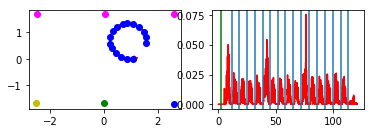

In [5]:
num = '1'
#num = '2'
#num = str(input('Take 1 or 2: '))

if num == '1':
    fn = 'Nao Pics/07-06-1630/Take 1/Take 2018-06-07 04.27.15 PM NAO.csv'
elif num == '2':
    fn = 'Nao Pics/07-06-1630/Take 2/Take 2018-06-07 05.44.48 PM NAO.csv'

def landmark_detec():
    folder = 'Nao Pics/07-06-1630/landmarks/*.csv'

    landmark_names = list()
    landmark_coords = list()
    for fn in glob.glob(folder):
        landmark_names.append(fn[-6:-4])
        x = 0
        y = 0
        c = 0
        with open(fn) as f:
            data = [line.split() for line in f]
        for d in data[7:]:
            x = x + float(d[0].split(',')[2])
            y = y + float(d[0].split(',')[4])
            c = c + 1
        landmark_coords.append([x/c, y/c])
        x = 0
        y = 0
        c = 0
    for i in range(len(landmark_coords)):
        landmark_coords[i].append(i)
    return landmark_names, landmark_coords

with open(fn) as f:
    print fn
    pic_t_start = int(fn[-13:-11])
    data = [line.split() for line in f]
    x = list()
    y = list()
    w = list()
    for d in data[7:]:
        d_split = d[0].split(',')
        x.append(float(d_split[6]))
        y.append(float(d_split[8]))
        w.append(float(d_split[5]))

eucl = list()
for n in range(len(x)):
    xn = x[n]
    yn = y[n]
    try:
        xn_plus = x[n+10]
        yn_plus = y[n+10]
        eucl.append(math.sqrt((xn - xn_plus)**2 + (yn - yn_plus)**2))
    except:
        break

img_time = list()
correction_val = 11
biggest_pic_t = 0
for fn in glob.glob('Nao Pics/07-06-1630/Take ' + num + '/img/*.jpg'):
    pic_t = int(fn[-6:-4]) - pic_t_start - correction_val
    while pic_t < biggest_pic_t:
        pic_t = pic_t + 60
    biggest_pic_t = pic_t
    img_time.append(pic_t)

landmark_names, landmark_coords = landmark_detec()

actual_mu = list()
t = [v / 120. for v in range(0, len(eucl))]
plt.subplot(221)
plt.plot(x, y, 'r-')
for j in landmark_coords:
    colour = landmark_names[j[2]][0]
    if colour == 'p':
        colour = 'magenta'
    plt.plot(j[0], j[1], color = colour, marker = 'o')
for i in img_time:
    print w[t.index(i)]
    actual_mu.append(np.matrix([[x[t.index(i)]], [y[t.index(i)]], [w[t.index(i)]]]))
    plt.plot(x[t.index(i)], y[t.index(i)], 'bo')
plt.subplot(222)
plt.plot(t, eucl, 'r-')
for i in img_time:
    plt.axvline(x = i)
plt.axvline(x = 2, c = 'green')
#plt.show()


## Detect Landmarks

In [6]:
z_data = detect_squares('1')


Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A27%3A38.jpg
[[ 3.82103229  3.61622715]
 [-0.36288402  0.50504477]
 [ 4.          5.        ]]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A27%3A44.jpg
[[ 3.82103229]
 [-0.11680459]
 [ 4.        ]]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A27%3A51.jpg
[[3.48388239]
 [0.1774931 ]
 [4.        ]]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A27%3A58.jpg
[]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A05.jpg
[[ 1.22592659]
 [-0.05985716]
 [ 3.        ]]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A11.jpg
[]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A18.jpg
[]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A24.jpg
[]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A31.jpg
[[ 2.09309791]
 [-0.29346634]
 [ 2.        ]]

Nao Pics/07-06-1630/Take 1/img\image.2018-06-06 04%3A28%3A38.jpg
[[1.9173416 ]
 [0.06027283]
 [2.        ]]

Nao Pics/07-06-1630/T

## Initialise Input

In [7]:
n = 0
for i in img_time:
    mu = np.matrix([[x[t.index(i)]], [y[t.index(i)]], [w[t.index(i)]]])
    Sigma = np.matrix([[1000., 0., 0.], [0., 1000., 0.], [0., 0., 1000.]]) 
    u = np.matrix([[0.20], [math.radians(20)]])
    c = z_data[n][2,:]
    print 'mu =\n', mu
    print 'Sigma = \n', Sigma
    print 'control = \n', u
    print 'z = \n', z_data[n]
    print 'c = \n', c
    n = n + 1
    print

mu =
[[ 1.083465]
 [-0.024482]
 [ 0.999223]]
Sigma = 
[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
control = 
[[0.2       ]
 [0.34906585]]
z = 
[[ 3.82103229  3.61622715]
 [-0.36288402  0.50504477]
 [ 4.          5.        ]]
c = 
[[4. 5.]]

mu =
[[ 0.857108]
 [-0.007634]
 [ 0.989113]]
Sigma = 
[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
control = 
[[0.2       ]
 [0.34906585]]
z = 
[[ 3.82103229]
 [-0.11680459]
 [ 4.        ]]
c = 
[[4.]]

mu =
[[0.625839]
 [0.077076]
 [0.952985]]
Sigma = 
[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
control = 
[[0.2       ]
 [0.34906585]]
z = 
[[3.48388239]
 [0.1774931 ]
 [4.        ]]
c = 
[[4.]]

mu =
[[0.435695]
 [0.210606]
 [0.903859]]
Sigma = 
[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
control = 
[[0.2       ]
 [0.34906585]]
z = 
[]
c = 
[]

mu =
[[0.289878]
 [0.410693]
 [0.804214]]
Sigma = 
[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
control = 
[[0

In [1]:
ekf_time_list = list()
eif_time_list = list()
before_ekf = list()
before_eif = list()

est_cor_k_list = list()
est_cor_i_list = list()

## Optimization Process
The process has been used to find the optimal points for the data, thus it is far from pretty as it has changed constantly.

In [ ]:
interval_multiplier = 1

t0 = time.time()
sig_r = 8.4#0.4
sig_theta = 0.5#0.3
sig_s = 0.0#1.0
monster_sigs = np.matrix([[0.],[0.],[0.],[0.]])
#monster_sigs = np.matrix([[0.],[0.],[0.]])
monster_summy_ekf = np.array([100.])
monster_summy_eif = np.array([100.])
for nalpha_1 in [1]:#range(-5,-3):
    alpha_1 = nalpha_1 / 10.
    for nalpha_2 in [1]:#range(-5,-3):
        alpha_2 = nalpha_2 / 10.
        for nalpha_3 in [0]:#range(-5,-3):
            alpha_3 = nalpha_3 / 10.
            for nalpha_4 in [1]:#range(-5,-3):
                alpha_4 = nalpha_4 / 10.
#for sig_rn in [84]:#range(30,90,1):#-10,10):#-20,20):
#    sig_r = float(sig_rn / 10.)
#    for sig_thetan in [5]:#range(-10,10, 1):#-27,5):
#        sig_theta = float(sig_thetan / 10.)
                #monster_sigs = np.concatenate((monster_sigs, [[sig_r],[sig_theta],[sig_s]]), axis=1)
                monster_sigs = np.concatenate((monster_sigs, [[alpha_1],[alpha_2],[alpha_3],[alpha_4]]), axis=1)
                Q = np.matrix([[sig_r, 0., 0.],[0., sig_theta, 0.],[0., 0., sig_s]])
                #print Q
                print alpha_1, alpha_2, alpha_3, alpha_4

                u = np.matrix([[0.20], [math.radians(20)]]) * interval_multiplier
        #        u = np.matrix([[0.40], [math.radians(40)]])

                estimations_EKF_mu = list()
                estimations_EIF_mu = list()

                initial_mu = np.matrix([[x[t.index(1)]], [y[t.index(1)]], [pi * w[t.index(1)]]])
                initial_Sigma = np.matrix([[1000., 0., 0.], [0., 1000., 0.], [0., 0., 1000.]])       

                ekf_time = time.time()
                # run the EKF estimation
                mu = initial_mu
                Sigma = initial_Sigma
                #for z in z_data:
                for zz in range(0,len(z_data),interval_multiplier):
                    z = z_data[zz]
                    #print zz
                    before_time = time.time()
                    mu, Sigma, est_cor_k = EKF_localization(mu, Sigma, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
                    est_cor_k_list.append(est_cor_k)
                    before_ekf.append(time.time() - before_time)
                    estimations_EKF_mu.append(mu)
                ekf_time_list.append(time.time() - ekf_time)
                #print 'ekf time: ', time.time() - ekf_time
                #print 'blob'
                eif_time = time.time()
                # run the EIF estimation
                Omega = inv(initial_Sigma)
                xi = Omega * initial_mu
                #for z in z_data:
                for zz in range(0,len(z_data),interval_multiplier):
                    z = z_data[zz]
                    #print zz
                    before_time = time.time()
                    xi, Omega, est_cor_i = EIF_localization(xi, Omega, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
                    est_cor_i_list.append(est_cor_i)
                    before_eif.append(time.time() - before_time)
                    appendable_Sigma = inv(Omega)
                    appendable_mu = appendable_Sigma * xi
                    estimations_EIF_mu.append(appendable_mu)
                eif_time_list.append(time.time() - eif_time)
                #print 'eif time: ', time.time() - eif_time

                plt.subplot(121)
                plt.plot(initial_mu[0], initial_mu[1], marker=(3, 0, math.degrees(initial_mu[2] * pi) - 90), markersize=10, c='g', linestyle='None')
                plt.plot([initial_mu[0,0], initial_mu[0,0] + cos(initial_mu[2,0] * pi) * 0.5], [initial_mu[1,0], initial_mu[1,0] + sin(initial_mu[2,0] * pi) * 0.5], c='g', linestyle = '--')
                plt.xlabel('x position field (m)')
                plt.ylabel('y position field (m)')
                plt.subplot(122)
                plt.plot(initial_mu[0], initial_mu[1], marker=(3, 0, math.degrees(initial_mu[2] * pi) - 90), markersize=10, c='g', linestyle='None')
                plt.plot([initial_mu[0,0], initial_mu[0,0] + cos(initial_mu[2,0] * pi) * 0.5], [initial_mu[1,0], initial_mu[1,0] + sin(initial_mu[2,0] * pi) * 0.5], c='g', linestyle = '--')
                plt.xlabel('x position field (m)')
                plt.ylabel('y position field (m)')

                print math.degrees(initial_mu[2,0] * pi) % 360

                summy = [0,0]
                for k in range(len(estimations_EKF_mu)):
                    emu_K = estimations_EKF_mu[k]
                    emu_I = estimations_EIF_mu[k]
        #            amu = actual_mu[k]
                    amu = actual_mu[k*interval_multiplier]

                    # restoration of corruption in data
                    if k > 12:
                        amu[2,0] = amu[2,0] * -1
                    plt.subplot(121)
                    plt.title('EKF')
                    plt.plot([emu_K[0,0], amu[0,0]], [emu_K[1,0], amu[1,0]], 'y--')
                    plt.plot(emu_K[0], emu_K[1], marker=(3, 0, math.degrees(emu_K[2]) - 90), markersize=10, c='r', linestyle='None')
                    plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2] * pi) - 90), markersize=10, c='b', linestyle='None')
                    #plt.plot([emu_K[0,0], emu_K[0,0] + cos(emu_K[2,0] * pi) * 0.5], [emu_K[1,0], emu_K[1,0] + sin(emu_K[2,0] * pi) * 0.5], c='r', linestyle = '--')
                    plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * pi) * 0.5], [amu[1,0], amu[1,0] + sin(amu[2,0] * pi) * 0.5], c='b', linestyle = '--')

                    plt.subplot(122)
                    plt.title('EIF')
                    plt.plot([emu_I[0,0], amu[0,0]], [emu_I[1,0], amu[1,0]], 'y--')
                    plt.plot(emu_I[0], emu_I[1], marker=(3, 0, math.degrees(emu_I[2]) - 90), markersize=10, c='r', linestyle='None')
                    plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2] * pi) - 90), markersize=10, c='b', linestyle='None')
                    #plt.plot([emu_I[0,0], emu_I[0,0] + cos(emu_I[2,0]) * 0.5], [emu_I[1,0], emu_I[1,0] + sin(emu_I[2,0]) * 0.5], c='r', linestyle = '--')
                    plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * pi) * 0.5], [amu[1,0], amu[1,0] + sin(amu[2,0] * pi) * 0.5], c='b', linestyle = '--')

                    #print math.degrees(emu_I[2,0]), math.degrees(amu[2,0]* pi)


                    summy_ekf = math.sqrt((emu_K[0]-amu[0])**2+(emu_K[1]-amu[1])**2)
                    summy_eif = math.sqrt((emu_I[0]-amu[0])**2+(emu_I[1]-amu[1])**2)
                    summy[0] = summy[0] + summy_ekf
                    summy[1] = summy[1] + summy_eif
                    #print summy_ekf, summy_eif

                    # jupyter changes forever, so change back
                    if k > 12:
                        amu[2,0] = amu[2,0] * -1
                print summy
                monster_summy_ekf = np.concatenate((monster_summy_ekf, [summy[0]]))
                monster_summy_eif = np.concatenate((monster_summy_eif, [summy[1]]))
                plt.subplot(121)
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                plt.subplot(122)
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                plt.show()
print time.time()-t0

9.5
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
-0.9
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
0.4
13.8
4.38599991798
EKF 13.8 2.3166749674576947 0.14479218546610592 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 1.55395400429 0.119534923407 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]


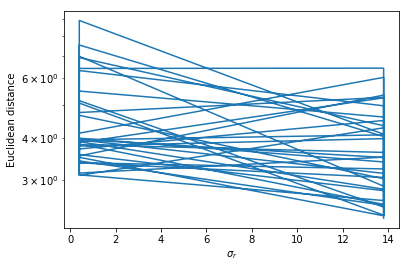

EIF 0.4 1.5946569297982285 0.09966605811238928 [0.4, 0.3, 9.5, -2.0, -1.2, 0.3]
EIF 0.4 1.10639927695 0.0851076366886 [0.4, 0.3, 9.5, -2.0, -1.2, 0.3]


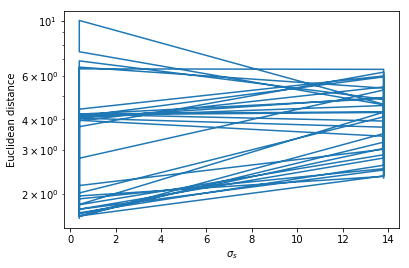

Both in one


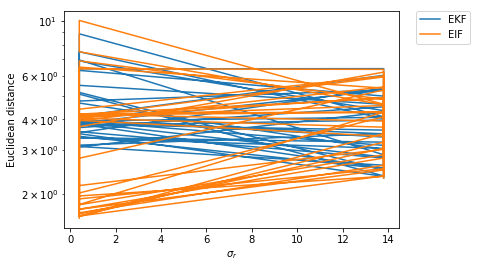

6.49500012398


In [65]:
timothy_time = time.time()
interval_multiplier = 1

t0 = time.time()
sig_r = 13.8#0.4
sig_theta = 0.9#0.3
#sig_r = 0.4
#sig_theta = 0.3
sig_s = 0.0
alpha_1 = -0.9#0.1
alpha_2 = 0.5#0.1
alpha_3 = -1.8#0.0
alpha_4 = 0.7#0.1
#alpha_1 = 9.5
#alpha_2 = -2.0
#alpha_3 = -1.2
#alpha_4 = 0.3
monster_sigs = np.matrix([[0.],[0.],[0.],[0.]])
#monster_sigs = np.matrix([[0.],[0.],[0.]])
monster_summy_ekf = np.array([100.])
monster_summy_eif = np.array([100.])

minus1_ekf = list()
minus1_eif = list()
minus2_ekf = list()
minus2_eif = list()
minus3_ekf = list()
minus3_eif = list()
minus4_ekf = list()
minus4_eif = list()
minus5_ekf = list()
minus5_eif = list()
minus6_ekf = list()
minus6_eif = list()
minus7_ekf = list()
minus7_eif = list()
minus8_ekf = list()
minus8_eif = list()
minus9_ekf = list()
minus9_eif = list()
minus10_ekf = list()
minus10_eif = list()
minus11_ekf = list()
minus11_eif = list()
minus12_ekf = list()
minus12_eif = list()
minus13_ekf = list()
minus13_eif = list()
minus14_ekf = list()
minus14_eif = list()
minus15_ekf = list()
minus15_eif = list()

optimize_var = np.arange(-10,10,0.05)
#optimize_var = np.arange(0,100,0.5)

optimize_var = list()
optimize_values = list()
optivar = 0

for nalpha_1 in [9.5,-0.9]:#optimize_var:
#for nalpha_1 in [-0.9]:#optimize_var:
    print nalpha_1
    alpha_1 = nalpha_1# / 100.
    for nalpha_2 in [-2.0,0.5]:#[0.5]:#np.arange(-10,10.1,0.1):#[-0.1]:#range(-5,-3):
    #for nalpha_2 in [0.5]:#np.arange(-10,10.1,0.1):#[-0.1]:#range(-5,-3):
        alpha_2 = nalpha_2# / 10.
        for nalpha_3 in [-1.2,-1.8]:#[-1.8]:#np.arange(-2,-1.0,0.1):#[0.2]:#range(-5,-3):
        #for nalpha_3 in [-1.8]:#np.arange(-2,-1.0,0.1):#[0.2]:#range(-5,-3):
            alpha_3 = nalpha_3# / 10.
            for nalpha_4 in [0.3,0.7]:#np.arange(-20.,20.,0.01):#[0.3]:#[0.7]:#np.arange(0,1.1,0.1):#[0.3]:#np.arange(-1.01,1.,0.01):#[0.1]:#np.arange(0.2,0.5,0.1):#[0.1]:# np.arange(-0.5,0.75,0.15):#[0.1]:#range(-5,-3):
            #for nalpha_4 in [0.7]:#np.arange(0,1.1,0.1):#[0.3]:#np.arange(-1.01,1.,0.01):#[0.1]:#np.arange(0.2,0.5,0.1):#[0.1]:# np.arange(-0.5,0.75,0.15):#[0.1]:#range(-5,-3):
                alpha_4 = nalpha_4# / 10.

#for blobby in [0]:
    #for sig_rn in np.arange(-1,15,0.1):#[-0.4]:#range(30,90,1):#-10,10):#-20,20):
                for sig_rn in [0.4,13.8]:#np.arange(-20,20,0.1):#[13.8]:#range(30,90,1):#-10,10):#-20,20):
                    print sig_rn
                    sig_r = float(sig_rn)
                    #for sig_thetan in np.arange(-1,1,0.1):#optimize_var:#[0.5]:#range(-10,10, 1):#-27,5):
                    for sig_thetan in [0.3,1.]:#optimize_var:#[0.5]:#range(-10,10, 1):#-27,5):
                        sig_theta = float(sig_thetan)
                        for sig_sn in [0]:#range(-10,10, 1):#-27,5):
                            sig_s = float(sig_sn)
                            #optimize_var.append(optivar)
                            optimize_var.append(sig_r)
                            optimize_values.append([sig_r, sig_theta, alpha_1, alpha_2, alpha_3, alpha_4])
                            #optimize_values.append([alpha_1, alpha_2, alpha_3, alpha_4])
                            optivar = optivar+1
                            #monster_sigs = np.concatenate((monster_sigs, [[sig_r],[sig_theta],[sig_s]]), axis=1)
                            monster_sigs = np.concatenate((monster_sigs, [[alpha_1],[alpha_2],[alpha_3],[alpha_4]]), axis=1)
                            Q = np.matrix([[sig_r, 0., 0.],[0., sig_theta, 0.],[0., 0., sig_s]])
                            #print Q
                            #print alpha_1, alpha_2, alpha_3, alpha_4
                            u = np.matrix([[0.20], [math.radians(20)]]) * interval_multiplier

                            estimations_EKF_mu = list()
                            estimations_EIF_mu = list()

                            initial_mu = np.matrix([[x[t.index(1)]], [y[t.index(1)]], [pi * w[t.index(1)]]])
                            initial_Sigma = np.matrix([[1000., 0., 0.], [0., 1000., 0.], [0., 0., 1000.]])       

                            ekf_time = time.time()
                            # run the EKF estimation
                            mu = initial_mu
                            Sigma = initial_Sigma
                            #for z in z_data:
                            for zz in range(0,len(z_data),interval_multiplier):
                                z = z_data[zz]
                                #print zz
                                before_time = time.time()
                                mu, Sigma, est_cor_k = EKF_localization(mu, Sigma, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
                                est_cor_k_list.append(est_cor_k)
                                before_ekf.append(time.time() - before_time)
                                estimations_EKF_mu.append(mu)
                            ekf_time_list.append(time.time() - ekf_time)
                            #print 'ekf time: ', time.time() - ekf_time
                            #print 'blob'
                            eif_time = time.time()
                            # run the EIF estimation
                            Omega = inv(initial_Sigma)
                            xi = Omega * initial_mu
                            #for z in z_data:
                            for zz in range(0,len(z_data),interval_multiplier):
                                z = z_data[zz]
                                #print zz
                                before_time = time.time()
                                xi, Omega, est_cor_i = EIF_localization(xi, Omega, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
                                est_cor_i_list.append(est_cor_i)
                                before_eif.append(time.time() - before_time)
                                appendable_Sigma = inv(Omega)
                                appendable_mu = appendable_Sigma * xi
                                estimations_EIF_mu.append(appendable_mu)
                            eif_time_list.append(time.time() - eif_time)
                            #print 'eif time: ', time.time() - eif_time


                            summy = [0,0]
                            list_of_eucl_dists_k = list()
                            list_of_eucl_dists_i = list()
                            for k in range(len(estimations_EKF_mu)):
                                emu_K = estimations_EKF_mu[k]
                                emu_I = estimations_EIF_mu[k]
                                amu = actual_mu[k*interval_multiplier]

                                # restoration of corruption in data
                                if k > 12:
                                    amu[2,0] = amu[2,0] * -1

                                summy_ekf = math.sqrt((emu_K[0]-amu[0])**2+(emu_K[1]-amu[1])**2)
                                summy_eif = math.sqrt((emu_I[0]-amu[0])**2+(emu_I[1]-amu[1])**2)
                                summy[0] = summy[0] + summy_ekf
                                summy[1] = summy[1] + summy_eif
                                list_of_eucl_dists_k.append(summy_ekf)
                                list_of_eucl_dists_i.append(summy_eif)
                                #print summy_ekf, summy_eif

                                # jupyter changes forever, so change back
                                if k > 12:
                                    amu[2,0] = amu[2,0] * -1
                            minus1_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(1, list_of_eucl_dists_k)))
                            minus1_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(1, list_of_eucl_dists_i)))
                            minus2_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(2, list_of_eucl_dists_k)))
                            minus2_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(2, list_of_eucl_dists_i)))
                            minus3_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(3, list_of_eucl_dists_k)))
                            minus3_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(3, list_of_eucl_dists_i)))
                            minus4_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(4, list_of_eucl_dists_k)))
                            minus4_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(4, list_of_eucl_dists_i)))
                            minus5_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(5, list_of_eucl_dists_k)))
                            minus5_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(5, list_of_eucl_dists_i)))
                            minus6_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(6, list_of_eucl_dists_k)))
                            minus6_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(6, list_of_eucl_dists_i)))
                            minus7_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(7, list_of_eucl_dists_k)))
                            minus7_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(7, list_of_eucl_dists_i)))
                            minus8_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(8, list_of_eucl_dists_k)))
                            minus8_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(8, list_of_eucl_dists_i)))
                            minus9_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(9, list_of_eucl_dists_k)))
                            minus9_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(9, list_of_eucl_dists_i)))
                            minus10_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(10, list_of_eucl_dists_k)))
                            minus10_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(10, list_of_eucl_dists_i)))
                            minus11_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(11, list_of_eucl_dists_k)))
                            minus11_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(11, list_of_eucl_dists_i)))
                            minus12_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(12, list_of_eucl_dists_k)))
                            minus12_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(12, list_of_eucl_dists_i)))
                            minus13_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(13, list_of_eucl_dists_k)))
                            minus13_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(13, list_of_eucl_dists_i)))
                            minus14_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(14, list_of_eucl_dists_k)))
                            minus14_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(14, list_of_eucl_dists_i)))
                            minus15_ekf.append(sum(list_of_eucl_dists_k) - sum(heapq.nlargest(15, list_of_eucl_dists_k)))
                            minus15_eif.append(sum(list_of_eucl_dists_i) - sum(heapq.nlargest(15, list_of_eucl_dists_i)))
                            #print summy
                            monster_summy_ekf = np.concatenate((monster_summy_ekf, [summy[0]]))
                            monster_summy_eif = np.concatenate((monster_summy_eif, [summy[1]]))
print time.time()-t0
print 'EKF', optimize_var[np.argmin(monster_summy_ekf[1:])], min(monster_summy_ekf[1:]), min(monster_summy_ekf[1:])/16, optimize_values[np.argmin(monster_summy_ekf[1:])]
print 'EKF', optimize_var[np.argmin(minus2_ekf)], min(minus2_ekf), min(minus2_ekf)/13, optimize_values[np.argmin(minus2_ekf)]
plt.xlabel(r'$\sigma_r$')
plt.ylabel('Euclidean distance')
plt.yscale('log')
plt.plot(optimize_var, monster_summy_ekf[1:])
plt.show()

print 'EIF', optimize_var[np.argmin(monster_summy_eif[1:])], min(monster_summy_eif[1:]), min(monster_summy_eif[1:])/16, optimize_values[np.argmin(monster_summy_eif[1:])]
print 'EIF', optimize_var[np.argmin(minus2_eif)], min(minus2_eif), min(minus2_eif)/13, optimize_values[np.argmin(minus2_eif)]
plt.xlabel(r'$\sigma_s$')
plt.ylabel('Euclidean distance')
plt.yscale('log')
plt.plot(optimize_var, monster_summy_eif[1:])
plt.show()

print 'Both in one'
plt.xlabel(r'$\sigma_r$')
plt.ylabel('Euclidean distance')
plt.yscale('log')
plt.plot(optimize_var, monster_summy_ekf[1:], label='EKF')
plt.plot(optimize_var, monster_summy_eif[1:], label='EIF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print time.time() - timothy_time

## Outlier Comparison

EKF 13.8 2.3166749674576947 0.14479218546610592 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 1.8963038662 0.126420257747 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 1.55395400429 0.110996714592 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 1.21649260002 0.0935763538474 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.93205940018 0.0776716166817 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.747318922591 0.0679380838719 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.607914023796 0.0607914023796 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.482286690592 0.0535874100657 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.381504538262 0.0476880672828 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.310325028091 0.0443321468702 [13.8, 1.0, -0.9, 0.5, -1.8, 0.7]
EKF 13.8 0.233963741261 0.0389939568769 [13.8, 0.3, -0.9, 0.5, -1.2, 0.7]
EKF 13.8 0.152880876355 0.030576175271 [13.8, 0.3, -0.9, 0.5, -1.2, 0.7]
EKF 13.8 0.0827454154017 0.0206863538504 [13.8, 0.3, -0.9, 0.5, -1.2, 0.7]
EKF 13.8 0.0367962870888 0.0122654290

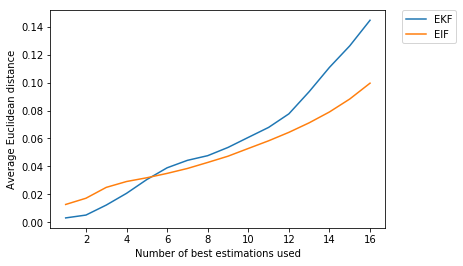

In [66]:
print 'EKF', optimize_var[np.argmin(monster_summy_ekf[1:])], min(monster_summy_ekf[1:]), min(monster_summy_ekf[1:])/16, optimize_values[np.argmin(monster_summy_ekf[1:])]
print 'EKF', optimize_var[np.argmin(minus1_ekf)], min(minus1_ekf), min(minus1_ekf)/15, optimize_values[np.argmin(minus1_ekf)]
print 'EKF', optimize_var[np.argmin(minus2_ekf)], min(minus2_ekf), min(minus2_ekf)/14, optimize_values[np.argmin(minus2_ekf)]
print 'EKF', optimize_var[np.argmin(minus3_ekf)], min(minus3_ekf), min(minus3_ekf)/13, optimize_values[np.argmin(minus3_ekf)]
print 'EKF', optimize_var[np.argmin(minus4_ekf)], min(minus4_ekf), min(minus4_ekf)/12, optimize_values[np.argmin(minus4_ekf)]
print 'EKF', optimize_var[np.argmin(minus5_ekf)], min(minus5_ekf), min(minus5_ekf)/11, optimize_values[np.argmin(minus5_ekf)]
print 'EKF', optimize_var[np.argmin(minus6_ekf)], min(minus6_ekf), min(minus6_ekf)/10, optimize_values[np.argmin(minus6_ekf)]
print 'EKF', optimize_var[np.argmin(minus7_ekf)], min(minus7_ekf), min(minus7_ekf)/9, optimize_values[np.argmin(minus7_ekf)]
print 'EKF', optimize_var[np.argmin(minus8_ekf)], min(minus8_ekf), min(minus8_ekf)/8, optimize_values[np.argmin(minus8_ekf)]
print 'EKF', optimize_var[np.argmin(minus9_ekf)], min(minus9_ekf), min(minus9_ekf)/7, optimize_values[np.argmin(minus9_ekf)]
print 'EKF', optimize_var[np.argmin(minus10_ekf)], min(minus10_ekf), min(minus10_ekf)/6, optimize_values[np.argmin(minus10_ekf)]
print 'EKF', optimize_var[np.argmin(minus11_ekf)], min(minus11_ekf), min(minus11_ekf)/5, optimize_values[np.argmin(minus11_ekf)]
print 'EKF', optimize_var[np.argmin(minus12_ekf)], min(minus12_ekf), min(minus12_ekf)/4, optimize_values[np.argmin(minus12_ekf)]
print 'EKF', optimize_var[np.argmin(minus13_ekf)], min(minus13_ekf), min(minus13_ekf)/3, optimize_values[np.argmin(minus13_ekf)]
print 'EKF', optimize_var[np.argmin(minus14_ekf)], min(minus14_ekf), min(minus14_ekf)/2, optimize_values[np.argmin(minus14_ekf)]
print 'EKF', optimize_var[np.argmin(minus15_ekf)], min(minus15_ekf), min(minus15_ekf)/1, optimize_values[np.argmin(minus15_ekf)]
print
print 'EIF', optimize_var[np.argmin(monster_summy_eif[1:])], min(monster_summy_eif[1:]), min(monster_summy_eif[1:])/16, optimize_values[np.argmin(monster_summy_eif[1:])]
print 'EIF', optimize_var[np.argmin(minus1_eif)], min(minus1_eif), min(minus1_eif)/15, optimize_values[np.argmin(minus1_eif)]
print 'EIF', optimize_var[np.argmin(minus2_eif)], min(minus2_eif), min(minus2_eif)/14, optimize_values[np.argmin(minus2_eif)]
print 'EIF', optimize_var[np.argmin(minus3_eif)], min(minus3_eif), min(minus3_eif)/13, optimize_values[np.argmin(minus3_eif)]
print 'EIF', optimize_var[np.argmin(minus4_eif)], min(minus4_eif), min(minus4_eif)/12, optimize_values[np.argmin(minus4_eif)]
print 'EIF', optimize_var[np.argmin(minus5_eif)], min(minus5_eif), min(minus5_eif)/11, optimize_values[np.argmin(minus5_eif)]
print 'EIF', optimize_var[np.argmin(minus6_eif)], min(minus6_eif), min(minus6_eif)/10, optimize_values[np.argmin(minus6_eif)]
print 'EIF', optimize_var[np.argmin(minus7_eif)], min(minus7_eif), min(minus7_eif)/9, optimize_values[np.argmin(minus7_eif)]
print 'EIF', optimize_var[np.argmin(minus8_eif)], min(minus8_eif), min(minus8_eif)/8, optimize_values[np.argmin(minus8_eif)]
print 'EIF', optimize_var[np.argmin(minus9_eif)], min(minus9_eif), min(minus9_eif)/7, optimize_values[np.argmin(minus9_eif)]
print 'EIF', optimize_var[np.argmin(minus10_eif)], min(minus10_eif), min(minus10_eif)/6, optimize_values[np.argmin(minus10_eif)]
print 'EIF', optimize_var[np.argmin(minus11_eif)], min(minus11_eif), min(minus11_eif)/5, optimize_values[np.argmin(minus11_eif)]
print 'EIF', optimize_var[np.argmin(minus12_eif)], min(minus12_eif), min(minus12_eif)/4, optimize_values[np.argmin(minus12_eif)]
print 'EIF', optimize_var[np.argmin(minus13_eif)], min(minus13_eif), min(minus13_eif)/3, optimize_values[np.argmin(minus13_eif)]
print 'EIF', optimize_var[np.argmin(minus14_eif)], min(minus14_eif), min(minus14_eif)/2, optimize_values[np.argmin(minus14_eif)]
print 'EIF', optimize_var[np.argmin(minus15_eif)], min(minus15_eif), min(minus15_eif)/1, optimize_values[np.argmin(minus15_eif)]


ekf_opt_mins = [min(monster_summy_ekf[1:])/16,min(minus1_ekf)/15,min(minus2_ekf)/14,min(minus3_ekf)/13,min(minus4_ekf)/12,min(minus5_ekf)/11,min(minus6_ekf)/10,min(minus7_ekf)/9,min(minus8_ekf)/8,min(minus9_ekf)/7,min(minus10_ekf)/6,min(minus11_ekf)/5,min(minus12_ekf)/4,min(minus13_ekf)/3,min(minus14_ekf)/2,min(minus15_ekf)/1]
eif_opt_mins = [min(monster_summy_eif[1:])/16,min(minus1_eif)/15,min(minus2_eif)/14,min(minus3_eif)/13,min(minus4_eif)/12,min(minus5_eif)/11,min(minus6_eif)/10,min(minus7_eif)/9,min(minus8_eif)/8,min(minus9_eif)/7,min(minus10_eif)/6,min(minus11_eif)/5,min(minus12_eif)/4,min(minus13_eif)/3,min(minus14_eif)/2,min(minus15_eif)/1]

print ekf_opt_mins
print eif_opt_mins
print np.arange(16,0,-1)
plt.xlabel('Number of best estimations used')
plt.ylabel('Average Euclidean distance')
#plt.yscale('log')
plt.plot(np.arange(16,0,-1), ekf_opt_mins, label='EKF')
plt.plot(np.arange(16,0,-1), eif_opt_mins, label='EIF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## EKF vs EIF
Both EKF and EIF have a function to easily run them with different values

In [36]:
def localizer_ekf(sig_r, sig_theta, sig_s, alpha_1, alpha_2, alpha_3, alpha_4, interval_multiplier):
    total_eucl_dist = list()
    #monster_sigs = np.concatenate((monster_sigs, [[alpha_1],[alpha_2],[alpha_3],[alpha_4]]), axis=1)
    Q = np.matrix([[sig_r, 0., 0.],[0., sig_theta, 0.],[0., 0., sig_s]])

    u = np.matrix([[0.20], [math.radians(20)]]) * interval_multiplier

    estimations_EKF_mu = list()

    initial_mu = np.matrix([[x[t.index(1)]], [y[t.index(1)]], [pi * w[t.index(1)]]])
    initial_Sigma = np.matrix([[1000., 0., 0.], [0., 1000., 0.], [0., 0., 1000.]])       

    # run the EKF estimation
    mu = initial_mu
    Sigma = initial_Sigma
    #for z in z_data:
    for zz in range(0,len(z_data),interval_multiplier):
        z = z_data[zz]
        #print zz
        before_time = time.time()
        mu, Sigma, est_cor_k = EKF_localization(mu, Sigma, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
        est_cor_k_list.append(est_cor_k)
        before_ekf.append(time.time() - before_time)
        estimations_EKF_mu.append(mu)



    for k in range(len(estimations_EKF_mu)):
        emu_K = estimations_EKF_mu[k]
        amu = actual_mu[k*interval_multiplier]

        total_eucl_dist.append(math.sqrt((amu[0,0] - emu_K[0,0])**2 + (amu[1,0] - emu_K[1,0])**2))

        # restoration of corruption in data
        if k > 12:
            amu[2,0] = amu[2,0] * -1
        #plt.plot([emu_K[0,0], amu[0,0]], [emu_K[1,0], amu[1,0]], 'y--')
        plt.plot(emu_K[0], emu_K[1], marker=(3, 0, math.degrees(emu_K[2]) - 90), markersize=10, c='r', linestyle='None')
        plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2] * pi) - 90), markersize=10, c='b', linestyle='None')
        plt.plot([emu_K[0,0], emu_K[0,0] + cos(emu_K[2,0]) * 0.25], [emu_K[1,0], emu_K[1,0] + sin(emu_K[2,0]) * 0.25], c='r', linestyle = '--')
        plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * pi) * 0.25], [amu[1,0], amu[1,0] + sin(amu[2,0] * pi) * 0.25], c='b', linestyle = '--')

        # jupyter changes forever, so change back
        if k > 12:
            amu[2,0] = amu[2,0] * -1

    print 'EKF', sum(total_eucl_dist), sum(total_eucl_dist)/len(total_eucl_dist)
    plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2,0] * -pi) - 90), markersize=10, c='b', linestyle='None', label='Real pose')
    plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * -pi) * 0.25], [amu[1,0], amu[1,0] + sin(amu[2,0] * -pi) * 0.25], c='b', linestyle = '--', label='Real orientation')
    plt.plot(emu_K[0], emu_K[1], marker=(3, 0, math.degrees(emu_K[2]) - 90), markersize=10, c='r', linestyle='None', label='Estimated pose')
    plt.plot([emu_K[0,0], emu_K[0,0] + cos(emu_K[2,0]) * 0.25], [emu_K[1,0], emu_K[1,0] + sin(emu_K[2,0]) * 0.25], c='r', linestyle = '--', label='Estimated orientation')
    plt.plot(initial_mu[0], initial_mu[1], marker=(3, 0, math.degrees(initial_mu[2] * pi) - 90), markersize=10, c='g', linestyle='None', label='Initial pose')
    plt.plot([initial_mu[0,0], initial_mu[0,0] + cos(initial_mu[2,0] * pi) * 0.25], [initial_mu[1,0], initial_mu[1,0] + sin(initial_mu[2,0] * pi) * 0.25], c='g', linestyle = '--', label='Initial orientation')
    plt.xlabel('x position field (m)')
    plt.ylabel('y position field (m)')
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('plotties_auto_save/ekf'+'_'+str(alpha_1)+'_'+str(alpha_2)+'_'+str(alpha_3)+'_'+str(alpha_4)+'_'+str(sig_r)+'_'+str(sig_theta)+'_'+str(sum(total_eucl_dist))+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    return sum(total_eucl_dist)

def localizer_eif(sig_r, sig_theta, sig_s, alpha_1, alpha_2, alpha_3, alpha_4, interval_multiplier):
    total_eucl_dist = list()
    #monster_sigs = np.concatenate((monster_sigs, [[alpha_1],[alpha_2],[alpha_3],[alpha_4]]), axis=1)
    Q = np.matrix([[sig_r, 0., 0.],[0., sig_theta, 0.],[0., 0., sig_s]])

    u = np.matrix([[0.20], [math.radians(20)]]) * interval_multiplier

    estimations_EIF_mu = list()

    initial_mu = np.matrix([[x[t.index(1)]], [y[t.index(1)]], [pi * w[t.index(1)]]])
    initial_Sigma = np.matrix([[1000., 0., 0.], [0., 1000., 0.], [0., 0., 1000.]])       

    # run the EIF estimation
    Omega = inv(initial_Sigma)
    xi = Omega * initial_mu
    #for z in z_data:
    for zz in range(0,len(z_data),interval_multiplier):
        z = z_data[zz]
        #print zz
        before_time = time.time()
        xi, Omega, est_cor_i = EIF_localization(xi, Omega, u, z, z[2,:], landmark_coords, Q, alpha_1, alpha_2, alpha_3, alpha_4)
        est_cor_i_list.append(est_cor_i)
        before_eif.append(time.time() - before_time)
        appendable_Sigma = inv(Omega)
        appendable_mu = appendable_Sigma * xi
        estimations_EIF_mu.append(appendable_mu)

    

    for k in range(len(estimations_EIF_mu)):
        emu_I = estimations_EIF_mu[k]
        amu = actual_mu[k*interval_multiplier]

        total_eucl_dist.append(math.sqrt((amu[0,0] - emu_I[0,0])**2 + (amu[1,0] - emu_I[1,0])**2))

        # restoration of corruption in data
        if k > 12:
            amu[2,0] = amu[2,0] * -1
        #plt.plot([emu_K[0,0], amu[0,0]], [emu_K[1,0], amu[1,0]], 'y--')
        plt.plot(emu_I[0], emu_I[1], marker=(3, 0, math.degrees(emu_I[2]) - 90), markersize=10, c='r', linestyle='None')
        plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2] * pi) - 90), markersize=10, c='b', linestyle='None')
        plt.plot([emu_I[0,0], emu_I[0,0] + cos(emu_I[2,0]) * 0.25], [emu_I[1,0], emu_I[1,0] + sin(emu_I[2,0]) * 0.25], c='r', linestyle='--')
        plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * pi) * 0.25], [amu[1,0], amu[1,0] + sin(amu[2,0] * pi) * 0.25], c='b', linestyle='--')

        # jupyter changes forever, so change back
        if k > 12:
            amu[2,0] = amu[2,0] * -1
    
    
    print 'EIF', sum(total_eucl_dist), sum(total_eucl_dist)/len(total_eucl_dist)
    
    plt.plot(amu[0], amu[1], marker=(3, 0, math.degrees(amu[2,0] * -pi) - 90), markersize=10, c='b', linestyle='None', label='Real pose' )
    plt.plot([amu[0,0], amu[0,0] + cos(amu[2,0] * -pi) * 0.25], [amu[1,0], amu[1,0] + sin(amu[2,0] * -pi) * 0.25], c='b', linestyle = '--', label='Real orientation' )
    plt.plot(emu_I[0], emu_I[1], marker=(3, 0, math.degrees(emu_I[2]) - 90), markersize=10, c='r', linestyle='None', label='Estimated pose')
    plt.plot([emu_I[0,0], emu_I[0,0] + cos(emu_I[2,0]) * 0.25], [emu_I[1,0], emu_I[1,0] + sin(emu_I[2,0]) * 0.25], c='r', linestyle = '--', label='Estimated orientation')
    plt.plot(initial_mu[0], initial_mu[1], marker=(3, 0, math.degrees(initial_mu[2] * pi) - 90), markersize=10, c='g', linestyle='None', label='Initial Pose')
    plt.plot([initial_mu[0,0], initial_mu[0,0] + cos(initial_mu[2,0] * pi) * 0.25], [initial_mu[1,0], initial_mu[1,0] + sin(initial_mu[2,0] * pi) * 0.25], c='g', linestyle = '--', label='Initial orientation')
    plt.xlabel('x position field (m)')
    plt.ylabel('y position field (m)')
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('plotties_auto_save/eif'+'_'+str(alpha_1)+'_'+str(alpha_2)+'_'+str(alpha_3)+'_'+str(alpha_4)+'_'+str(sig_r)+'_'+str(sig_theta)+'_'+str(sum(total_eucl_dist))+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    return sum(total_eucl_dist)

## Run EKF and EIF
Plot their estimations

EKF 2.31640832383 0.144775520239


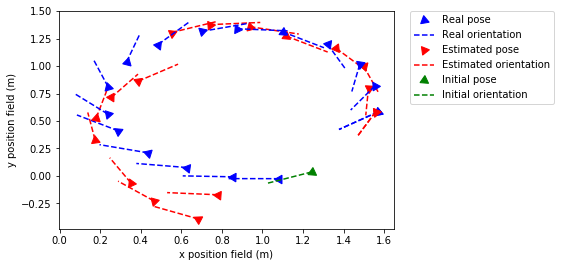

ekf_-0.9_0.5_-1.8_0.7_14.2_1.0_2.31640832383
EIF 1.5946569298 0.0996660581124


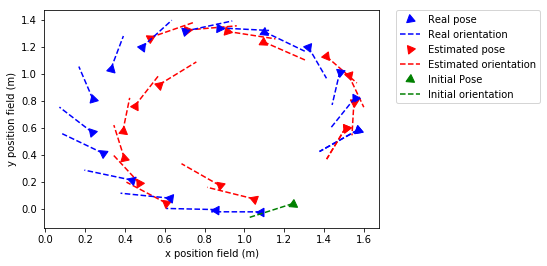

In [63]:
interval_multiplier = 1
sig_s = 0.0

alpha_1 = -0.9
alpha_2 = 0.5
alpha_3 = -1.8#
alpha_4 = 0.7
sig_r = 14.2
sig_theta = 1.0
sum_eucl = localizer_ekf(sig_r, sig_theta, sig_s, alpha_1, alpha_2, alpha_3, alpha_4, interval_multiplier)
print 'ekf'+'_'+str(alpha_1)+'_'+str(alpha_2)+'_'+str(alpha_3)+'_'+str(alpha_4)+'_'+str(sig_r)+'_'+str(sig_theta)+'_'+str(sum_eucl)

alpha_1 = 9.5#46.7
alpha_2 = -2.0#0.4
alpha_3 = -1.2#0.2
alpha_4 = 0.3
sig_r = 0.4
sig_theta = 0.3
sum_eucl = localizer_eif(sig_r, sig_theta, sig_s, alpha_1, alpha_2, alpha_3, alpha_4, interval_multiplier)